# Notebook 03 - Drought in the Netherlands with Time Series Modeling

*Martin Vonk - 2022*

This notebooks shows a quick calculation of the SPI, SPEI and SGI for De Bilt, in the Netherlands. The SGI is calculated using a [Pastas](https://github.com/pastas/pastas) time series model since the original time series is too short. The application of time series models for extrapolating groundwater time series is discussed in [Brakkee et al (2022)](https://hess.copernicus.org/articles/26/551/2022/hess-26-551-2022.html).

## Required packages

In [1]:
import datetime
import spei as si
import pandas as pd
import pastas as ps
import hydropandas as hpd
import scipy.stats as scs
import matplotlib.pyplot as plt

## Import time series

Time series are imported using the package hydropandas. Enddate is by default yesterday. The head time series is obtained from a Pastas test dataset.

In [2]:
yesterday = (datetime.date.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
prec = hpd.PrecipitationObs.from_knmi(260, startdate='1959-07-01', enddate=yesterday).multiply(1e3).squeeze()
prec.index = prec.index.normalize()
evap = hpd.EvaporationObs.from_knmi(260, startdate='1959-07-01', enddate=yesterday).multiply(1e3).squeeze()
evap.index = evap.index.normalize()
head = pd.read_csv('https://raw.githubusercontent.com/pastas/test-datasets/main/vanderspek_bakker_2017/B32C0572_DE-BILT.csv', index_col=0, parse_dates=True, sep=';')

## Calculate SPI and SPEI

In [3]:
# Accumulate time series on monthly basis
f = 30
p = prec.rolling(f'{f}D', min_periods=f).sum().iloc[f:]
pe = (prec - evap).rolling(f'{f}D', min_periods=f).sum().iloc[f:]

spi = si.si.spi(p, dist=scs.gamma)
spei = si.si.spei(pe, dist=scs.fisk)

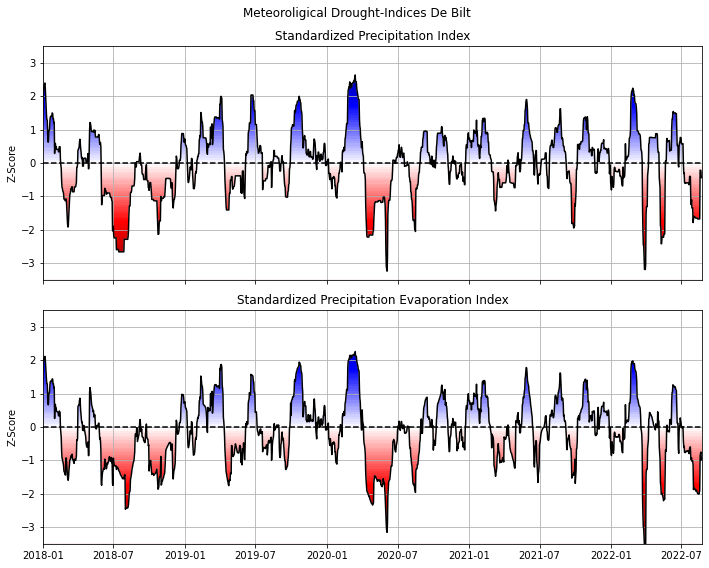

In [4]:
xlim = pd.to_datetime(['2018-01-01', yesterday])

fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)
si.plot.si(spi, bound=3.5, ax=axs[0])
si.plot.si(spei, bound=3.5, ax=axs[1])
[(x.grid(), x.set_xlim(xlim), x.set_ylabel('Z-Score')) for x in axs]
axs[0].set_title('Standardized Precipitation Index')
axs[1].set_title('Standardized Precipitation Evaporation Index')
fig.suptitle('Meteoroligical Drought-Indices De Bilt')
fig.tight_layout()

## Create time series model and simulate head 

INFO: Cannot determine frequency of series Head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series RH: freq=D
INFO: Inferred frequency for time series EV24: freq=D


Fit report Head                         Fit Statistics
nfev    24                     EVP               77.16
nobs    1187                   R2                 0.77
noise   True                   RMSE               0.11
tmin    1970-07-01 00:00:00    AIC            -5976.46
tmax    2020-12-28 00:00:00    BIC            -5935.83
freq    D                      Obj                3.81
warmup  3650 days 00:00:00     ___                    
solver  LeastSquares           Interp.              No

Parameters (8 optimized)
                   optimal   stderr     initial   vary
recharge_A        0.411772   ±5.50%    0.448615   True
recharge_a      125.511054   ±5.67%   10.000000   True
recharge_srmax   42.893840  ±13.36%  250.000000   True
recharge_lp       0.250000    ±nan%    0.250000  False
recharge_ks     372.095188  ±73.25%  100.000000   True
recharge_gamma    4.578569  ±14.30%    2.000000   True
recharge_kv       1.000000    ±nan%    1.000000  False
recharge_simax    2.000000    ±nan%    

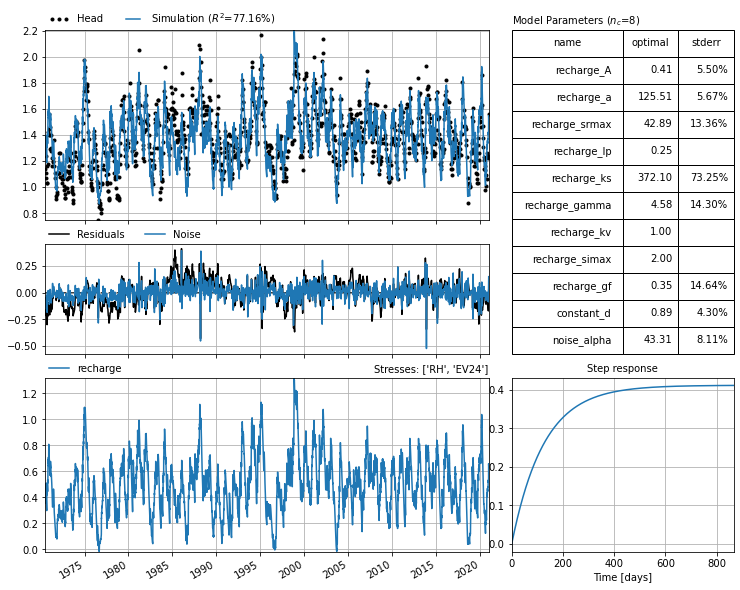

In [5]:
h = head['Head [m] B32C0572_DE-BILT'].rename('Head').dropna()
ml = ps.Model(h)
rm = ps.RechargeModel(prec, evap, ps.Exponential, recharge=ps.rch.FlexModel(gw_uptake=True))
ml.add_stressmodel(rm)
ml.solve(tmin='1970-07-01', report=True)
ml.plots.results();

## Calculate SGI based on time series model

In [6]:
gws = ml.simulate(tmin='1990-07-01', tmax=yesterday)
sgi = si.si.sgi(gws.rolling('3D').mean())

## Compare three drought-indices (SPI, SPEI, SGI) in plot

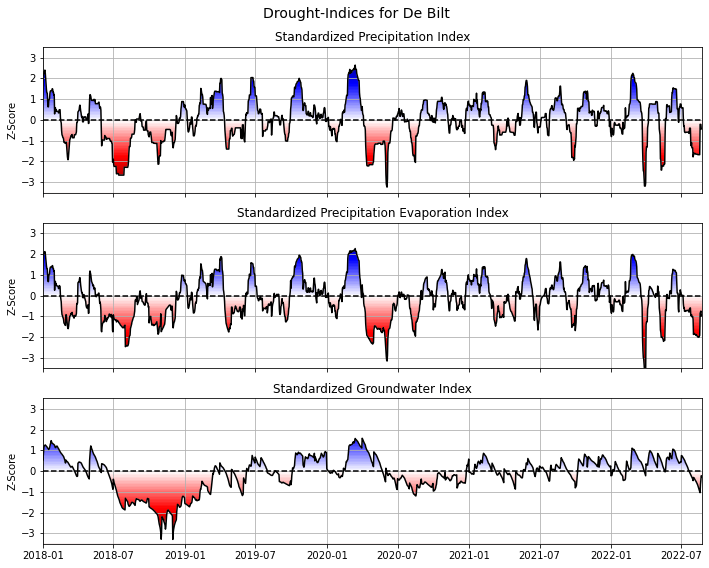

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(10,8), sharex=True)
si.plot.si(spi, bound=3.5, ax=axs[0])
si.plot.si(spei, bound=3.5, ax=axs[1])
si.plot.si(sgi, bound=3.5, ax=axs[2])
[(x.grid(), x.set_xlim(xlim), x.set_ylabel('Z-Score')) for x in axs]
axs[0].set_title('Standardized Precipitation Index')
axs[1].set_title('Standardized Precipitation Evaporation Index')
axs[2].set_title('Standardized Groundwater Index')
fig.suptitle('Drought-Indices for De Bilt', fontsize=14)
fig.tight_layout()
# fig.savefig('Drought_Index_Bilt.png', dpi=600, bbox_inches='tight')